# SVM

### Import libraries

In [1]:
import pandas as pd # one-hot encoding
import numpy as np
import os

import matplotlib.pyplot as plt # graphs
import matplotlib.colors as colors

from collections import defaultdict

from sklearn.utils import resample # downsample dataset
from sklearn.model_selection import train_test_split # split to training and testing datasets
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # support vector classifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords

### Import data

We work with 1956 comments from 5 different YouTube videos. The [YouTube Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection#) is freely available.

In [2]:
corpus = pd.read_csv("../data/YouTube-Spam-Collection/Youtube01-Psy.csv")
corpus.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [3]:
print(f"The corpus contains of {len(corpus)} comments.")

The corpus contains of 350 comments.


### Peprocessing

In [4]:
# remove blank rows if any
#corpus["CONTENT"].dropna(inplace=True)

# lower case
#corpus["CONTENT"] = [entry.lower() for entry in corpus["CONTENT"]]

# drop irrelevant features
irrelevant_features = ["COMMENT_ID", "AUTHOR", "DATE"]
corpus.drop(irrelevant_features, inplace=True, axis=1)
corpus.head()

# change column name
#corpus.rename({"CONTENT":"COMMENT"}, axis=1, inplace=True)
#corpus.head()


nltk.download('stopwords')
nltk.download('omw-1.4')

cleanedData = []
lemma = WordNetLemmatizer()
stop_words = stopwords.words("english")
for comment in corpus["CONTENT"]:    
    # Tokenizing and lemmatizing
    comment = nltk.word_tokenize(comment.lower())
    comment = [lemma.lemmatize(word) for word in comment]
    
    # Removing stopwords
    comment = [word for word in comment if word not in stop_words]
    
    # Joining
    comment = " ".join(comment)
    
    cleanedData.append(comment)

[nltk_data] Downloading package stopwords to /home/vivi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vivi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)

### Statistics

In [6]:
print(f"Data types:\n{corpus.dtypes}\n")
print(f"There are {len(corpus['CLASS'].unique())} comment types: {corpus['CLASS'].unique()}")
print(f"The dataset contains of {len(corpus)} examples: {len(corpus.loc[corpus['CLASS'] == 1])} spam and {len(corpus.loc[corpus['CLASS'] == 0])} legitimate comments")

Data types:
CONTENT    object
CLASS       int64
dtype: object

There are 2 comment types: [1 0]
The dataset contains of 350 examples: 175 spam and 175 legitimate comments


### Split the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(BOW,
                                                     np.asarray(corpus["CLASS"]),
                                                     test_size=0.3, # default is 0.25
                                                     random_state=42,
                                                     #stratify=y,  # if imbalanced dataset
                                                     shuffle=True
                                                    )

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(245, 1296)
(105, 1296)
(245,)
(105,)


### Support Vector Machine Classifier

In [9]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train, y_train)
predictions = clf_svm.predict(X_test)

print("Accuracy of the model is {}%".format(accuracy_score(predictions, y_test)*100))

Accuracy of the model is 94.28571428571428%


### Optimize parameters using cross validation

In [10]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

optimal_params = GridSearchCV(SVC(),
                              param_grid,
                              refit=True,
                              #scorng='accuracy',
                              verbose=2
                             )

optimal_params.fit(X_train, y_train)
print(f"Optimal parameters are {optimal_params.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C

In [11]:
clf_svm = SVC(C=100, 
              kernel='rbf',
              degree=3,
              gamma=0.01,
              tol=0.001,
              random_state=42,
             )

clf_svm.fit(X_train, y_train)

SVC(C=100, gamma=0.01, random_state=42)

### Evaluation

/home/vivi/uni/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy of the model is 99.04761904761905%


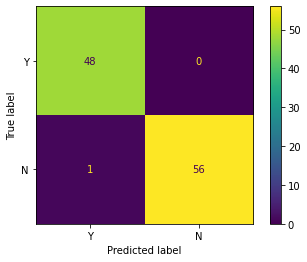

In [12]:
plot_confusion_matrix(clf_svm,
                      X_test,
                      y_test,
                      display_labels=['Y', 'N']
                     )

predictions = clf_svm.predict(X_test)
print("Accuracy of the model is {}%".format(accuracy_score(predictions, y_test)*100))